In [4]:
# ==========================================
# CELL 1: SETUP & DATA EXTRACTION
# ==========================================
!pip install -q "monai[nibabel, tqdm]"

import os
import glob
import tarfile
import torch
import numpy as np
from monai.utils import set_determinism

set_determinism(seed=0)

# --- EXTRACT DATA ---
tar_file_path = "/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar"
extract_dir = "/kaggle/working/brats_data"

if not os.path.exists(extract_dir):
    print(f"Extracting to {extract_dir}...")
    os.makedirs(extract_dir, exist_ok=True)
    with tarfile.open(tar_file_path, "r") as tar:
        tar.extractall(path=extract_dir)
    print("Extraction complete!")

# --- FIND FILES ---
train_images_flair = sorted(glob.glob(os.path.join(extract_dir, "**", "*_flair.nii.gz"), recursive=True))

data_dicts = []
for flair_path in train_images_flair:
    root = os.path.dirname(flair_path)
    pid = "_".join(os.path.basename(flair_path).split("_")[:-1])
    
    t1 = os.path.join(root, f"{pid}_t1.nii.gz")
    t1ce = os.path.join(root, f"{pid}_t1ce.nii.gz")
    t2 = os.path.join(root, f"{pid}_t2.nii.gz")
    seg = os.path.join(root, f"{pid}_seg.nii.gz")
    
    if os.path.exists(t1) and os.path.exists(seg):
        data_dicts.append({"image": [flair_path, t1, t1ce, t2], "label": seg})

# Split
train_files = data_dicts[:int(0.8*len(data_dicts))]
val_files = data_dicts[int(0.8*len(data_dicts)):]
print(f"Train: {len(train_files)} | Val: {len(val_files)}")

Extracting to /kaggle/working/brats_data...


/tmp/ipykernel_55/2819431204.py:23: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


Extraction complete!
Train: 1000 | Val: 251


In [5]:
# ==========================================
# CELL 2: 2D TRANSFORMS
# ==========================================
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    NormalizeIntensityd, MapTransform, EnsureTyped, 
    RandCropByPosNegLabeld, SqueezeDimd
)
from monai.data import Dataset, DataLoader

# Merge Labels: 1 (Necrosis), 2 (Edema), 4 (Enhancing) -> TC, WT, ET
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # TC (Necrotic + Enhancing)
            result.append(torch.logical_or(d[key] == 1, d[key] == 4))
            # WT (All 3)
            result.append(torch.logical_or(torch.logical_or(d[key] == 1, d[key] == 4), d[key] == 2))
            # ET (Enhancing)
            result.append(d[key] == 4)
            d[key] = torch.stack(result, axis=0).float()
        return d

train_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image"]),
    ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    
    # === THE 2D TRICK ===
    # 1. Crop a 224x224x1 slice. 
    #    pos=1, neg=0 means: Always pick a slice WITH a tumor label.
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=(224, 224, 1),
        pos=1,
        neg=0,
        num_samples=1,
        image_key="image",
        image_threshold=0,
    ),
    # 2. Squeeze the depth dim (make it 2D)
    SqueezeDimd(keys=["image", "label"], dim=-1),
    EnsureTyped(keys=["image", "label"]),
])

val_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image"]),
    ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    # For val, we just grab a center slice to test quickly
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=(224, 224, 1),
        pos=1, neg=0, num_samples=1
    ),
    SqueezeDimd(keys=["image", "label"], dim=-1),
    EnsureTyped(keys=["image", "label"]),
])

# Use Dataset (Safe Mode) - batch_size can be higher in 2D!
train_ds = Dataset(data=train_files, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)

val_ds = Dataset(data=val_files, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

print("2D DataLoaders Ready.")

2D DataLoaders Ready.


In [6]:
# ==========================================
# CELL 3: 2D MODEL & TRAINING
# ==========================================
from monai.networks.nets import SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2D Model
model = SegResNet(
    spatial_dims=2,  # <--- 2D
    init_filters=32, # We can afford more filters in 2D
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
scaler = torch.cuda.amp.GradScaler()

# Training Loop
max_epochs = 10
val_interval = 1
best_metric = -1
print(f"Starting 2D Training for {max_epochs} epochs...")

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        
        if step % 20 == 0:
             print(f"{step}/{len(train_ds)//train_loader.batch_size}, loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} avg loss: {epoch_loss/step:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                
                # No sliding window needed for 2D slices! Direct inference.
                val_outputs = model(val_inputs)
                
                # Binarize for metric
                val_outputs = (val_outputs.sigmoid() > 0.5).float()
                dice_metric(y_pred=val_outputs, y=val_labels)
            
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            
            if metric > best_metric:
                best_metric = metric
                torch.save(model.state_dict(), "best_metric_model_2d.pth")
                print(">>> New Best Model Saved!")
            
            print(f"Val Mean Dice: {metric:.4f} (Best: {best_metric:.4f})")

print("Done!")

Starting 2D Training for 10 epochs...


/tmp/ipykernel_55/1350562636.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_55/1350562636.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


20/125, loss: 0.7963
40/125, loss: 0.8115
60/125, loss: 0.7594
80/125, loss: 0.7448
100/125, loss: 0.8138
120/125, loss: 0.7800
Epoch 1 avg loss: 0.7740
>>> New Best Model Saved!
Val Mean Dice: 0.5720 (Best: 0.5720)
20/125, loss: 0.7590
40/125, loss: 0.6826
60/125, loss: 0.6662
80/125, loss: 0.7295
100/125, loss: 0.6778
120/125, loss: 0.7241
Epoch 2 avg loss: 0.7030
>>> New Best Model Saved!
Val Mean Dice: 0.6857 (Best: 0.6857)
20/125, loss: 0.6304
40/125, loss: 0.6282
60/125, loss: 0.6599
80/125, loss: 0.5227
100/125, loss: 0.6722
120/125, loss: 0.6227
Epoch 3 avg loss: 0.6369
>>> New Best Model Saved!
Val Mean Dice: 0.7320 (Best: 0.7320)
20/125, loss: 0.6487
40/125, loss: 0.4759
60/125, loss: 0.6267
80/125, loss: 0.4870
100/125, loss: 0.5574
120/125, loss: 0.4895
Epoch 4 avg loss: 0.5749
>>> New Best Model Saved!
Val Mean Dice: 0.7606 (Best: 0.7606)
20/125, loss: 0.5283
40/125, loss: 0.5269
60/125, loss: 0.3955
80/125, loss: 0.4560
100/125, loss: 0.5528
120/125, loss: 0.4913
Epoch 5 

In [12]:

import os
from IPython.display import FileLink

# 1. Define the file name
model_path = "best_metric_model_2d.pth"

# 2. Check if it exists
if os.path.exists(model_path):
    print(f"File found: {model_path}")
    print("Click the link below to download:")
    # 3. Generate Download Link
    display(FileLink(model_path))
else:
    print("Error: Model file not found. Did the training finish?")

File found: best_metric_model_2d.pth
Click the link below to download:


/kaggle/working/best_metric_model_2d.pth

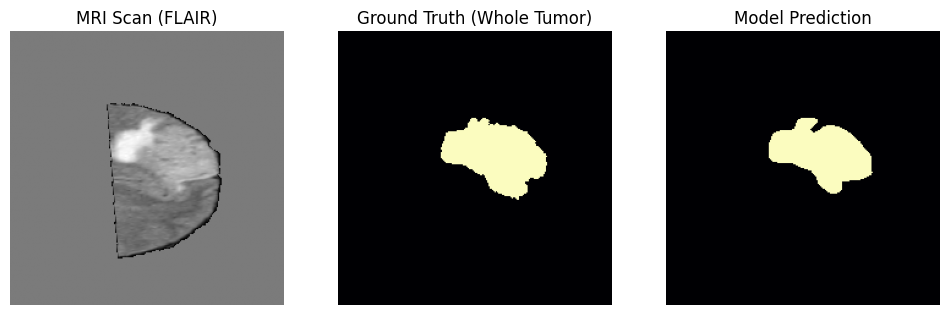

In [10]:

import matplotlib.pyplot as plt
import torch

model.eval()
with torch.no_grad():
    for batch_data in val_loader:
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)
        
        # 2. Predict
        outputs = model(inputs)
        outputs = (outputs.sigmoid() > 0.5).float() 
        
        break

img = inputs[0].cpu().numpy()
label = labels[0].cpu().numpy()
pred = outputs[0].cpu().numpy()

plt.figure(figsize=(12, 4))

# PLOT 1: The MRI Scan (FLAIR channel)
plt.subplot(1, 3, 1)
plt.title("MRI Scan (FLAIR)")
plt.imshow(img[0, :, :], cmap="gray")
plt.axis("off")


plt.subplot(1, 3, 2)
plt.title("Ground Truth (Whole Tumor)")
plt.imshow(label[1, :, :], cmap="magma") 
plt.axis("off")

# PLOT 3: Your Model's Prediction
plt.subplot(1, 3, 3)
plt.title("Model Prediction")
plt.imshow(pred[1, :, :], cmap="magma")
plt.axis("off")

plt.show()